In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from matplotlib import patches
from functools import reduce
import time
from PIL import Image, ImageDraw, ImageFont
from IPython.display import clear_output
from skimage.restoration import denoise_tv_bregman
from skimage import filters
from matplotlib import patches
from sklearn.cluster import KMeans
from scipy import signal
from scipy.signal import argrelextrema
import pandas as pd
from sklearn.cluster import KMeans

# Extracting and saving only walking frames 

In [2]:
def extract_walking_frames(meanxs, offset):
    
    b, a = signal.butter(5, 0.3)
    y = signal.filtfilt(b, a, np.array(meanxs), padlen=10)

    local_max_idx = argrelextrema(y, np.greater)
    local_min_idx = argrelextrema(y, np.less)

    walking_frames = []
    for imin,imax in zip(local_min_idx[0],local_max_idx[0]):
        if abs(imax-imin)<10:
            walking_frames.append((min(imax+offset,imin+offset),max(imax+offset,imin+offset)))
    return walking_frames

def merge_frame_indicies(walking_frames,thr_merging,thr_save):
    results = []
    count = 0 
    tuples = np.concatenate((walking_frames))

    for tuple_min_max in tuples:
        x = tuple_min_max[0]
        y = tuple_min_max[1]
        if count == 0:
            so_far = [x,y]
            count += 1
        else:
            if x - so_far[1] < thr_merging: 
                so_far[1] = y
            else:
                if so_far[1] - so_far[0] > thr_save:
                    results.append(so_far)
                count = 0
    return results

In [3]:
save_path = "./output/"
path = "../input/mouse-on-treadmill-frames/frames/"
folders = os.listdir(path)
print(folders)
if not os.path.exists(save_path):
        os.makedirs(save_path)
os.listdir(save_path)

['039350_left_20cms_0degUP', 'healthy_NSG336_1_20cms_0degUP', '039350_left_continue_20cms_0degUP', 'rightright_039348_2_20cms_0degUP', '039348_left_ninja_2_20cms_0degUP', 'leftleft039348_2_20cms_0degUP', 'right_right_039348_20cms_0degUP', 'healthy_NSG336_3_20cms_0degUP', 'right_right_039348_3_20cms_0degUP', '039350_left_left_20cms_0degUP', '036102healthy_continue_20cms_0degUP', 'left039348_20cms_0degUP']


[]

In [4]:
frames_ = {}
for fol in folders:
    try:
        file = os.listdir(path + fol)
        target_filename = path + fol + '/' + file[0]
        framesH = [path + fol + '/frames/' + f for f in os.listdir(path + fol + '/frames')]
        frames_[target_filename] = sorted(framesH, key = lambda x: (len(x.split('/')[-1]), x))
    except: 
        x = 0

In [5]:
# walking or not 
batch = []
images = []
dict_video = {}
walking_frames_videos = {}
offset = 400
disp = 0
    
for k in frames_.keys():

    walking_frames = []
    fname = k.split('image.')[0][0:-1]
    print(fname)
    names = frames_[k]
    sorted_names = sorted(names, key = lambda xx : int(xx.split('/')[-1].split('.')[0]))
    count = 0

    for frame_path in sorted_names:

        try:
            image_data = plt.imread(frame_path)
            image_data = np.int32(np.mean(image_data,axis = -1 ))
            batch.append(image_data)
        except:
            x = 1 

        print(len(batch),end='\r')

        if len(batch) >= offset:  
            o1 = offset * count
            count += 1 
            batch_arr = np.array(batch).squeeze()
            meanxs = [] 
            kk = 1
            count_index = 0
            diff_batch = batch_arr[0:-1,:,:] - batch_arr[1:,:,:] 
            for xx in diff_batch:
                count_index += 1 
                mean_x = np.mean(xx[:,0:600]>0,axis=0)
                b, a = signal.butter(8, 0.025)
                y = signal.filtfilt(b, a, np.array(mean_x), padlen=150)
                meanxs.append(np.argmax(y))
                if disp:
                    figure, ax = plt.subplots(2,2,figsize=(20,10))
                    ax[0][0].imshow(xx>0)
                    ax[0][1].imshow(batch_arr[count_index])


                    ax[1][0].plot(np.arange(kk),np.array(meanxs))
                    ax[1][1].plot(y)

                    kk += 1 
                    plt.show()
                    time.sleep(0.001) 
                    clear_output(wait=True)


            walking_frames.append(extract_walking_frames(meanxs,o1))
            batch = []

    walking_frames_videos[fname] = walking_frames 


pickle.dump(walking_frames_videos , open(save_path + 'walking_frames_all_videos.pickle','wb'))        


../input/mouse-on-treadmill-frames/frames/039350_left_20cms_0degUP
../input/mouse-on-treadmill-frames/frames/healthy_NSG336_1_20cms_0degUP
../input/mouse-on-treadmill-frames/frames/039350_left_continue_20cms_0degUP
../input/mouse-on-treadmill-frames/frames/rightright_039348_2_20cms_0degUP
../input/mouse-on-treadmill-frames/frames/039348_left_ninja_2_20cms_0degUP
../input/mouse-on-treadmill-frames/frames/leftleft039348_2_20cms_0degUP
../input/mouse-on-treadmill-frames/frames/right_right_039348_20cms_0degUP
../input/mouse-on-treadmill-frames/frames/healthy_NSG336_3_20cms_0degUP
../input/mouse-on-treadmill-frames/frames/right_right_039348_3_20cms_0degUP
../input/mouse-on-treadmill-frames/frames/039350_left_left_20cms_0degUP
../input/mouse-on-treadmill-frames/frames/036102healthy_continue_20cms_0degUP
../input/mouse-on-treadmill-frames/frames/left039348_20cms_0degUP


In [6]:
# collect all frames, concatenate, merge...
thr_merging = 30
thr_save = 50
new_dict = {}
for k in walking_frames_videos.keys():
    fints = []
    frame_intervals = walking_frames_videos[k]
    fints = merge_frame_indicies(frame_intervals,thr_merging,thr_save)
    new_dict[k] = fints
    
df = pd.DataFrame.from_dict(new_dict,orient='index')
df.to_csv(save_path +'frame_numbers.csv')

In [7]:
# spit out a text file containing all frames in a text file for training a paw detection. 
text_file = open(save_path +"mouse_walking.txt",'w')

for k in new_dict.keys():
    frames = new_dict[k]
    for frame in frames:
        for i in range(frame[0],frame[1]):
            image_file = k +'/frames/' + str(i) + '.jpg'
            text_file.write(image_file)
            text_file.write('\n')
            
text_file.close()

In [8]:
os.listdir(save_path)

['frame_numbers.csv', 'walking_frames_all_videos.pickle', 'mouse_walking.txt']

# Extraction paws and mouse body

In [9]:
def sliding_window(image, stepSizeX, stepSizeY, windowSizeX, windowSizeY, boundary = []):
    '''
    '''
    if len(boundary):
        x_boundary = boundary[0][0],boundary[0][1]
        y_boundary = boundary[1][0],boundary[1][1]
    else:
        x_boundary = 0 , image.shape[1]
        y_boundary = 0 , image.shape[0]
        
    for x in range(x_boundary[0], x_boundary[1], stepSizeX):
        for y in range(y_boundary[0],y_boundary[1] , stepSizeY):
            yield (x,y , image[y:y + windowSizeY, x:x + windowSizeX])

            
def get_boxes(arr_black,stepSizeX,stepSizeY,windowSizeX,windowSizeY , area , ratio , boundary = []):
    '''
    '''
    slide_ = sliding_window(arr_black.squeeze(),stepSizeX,stepSizeY,windowSizeX,windowSizeY, boundary)
    objs = []
    while True: 
        try:
            x,y , object_ = next(slide_)
            thr = np.sum(object_>1)
            if thr/area > ratio and y < 210 and x < 620: 
                objs.append((x,y))
        except:
            break
    rects = []
    rectangles = [] #save 

    if len(objs): 
        for point in objs:
            xx = point[0]
            yy = point[1]
            winX = windowSizeX
            winY = windowSizeY 
            rectangles.append(((xx,yy),(winX,winY)))
            rect = patches.Rectangle((xx,yy),winX,winY, edgecolor='b', facecolor="none")
            rects.append(rect)
            
    return rectangles , rects

def front_paw_mask(arr, mouse_location):
    '''
    '''
    boundary = ((mouse_location[0],int(mouse_location[2]/2)),(mouse_location[1],int(mouse_location[3])))
    stepSizeX = 10
    stepSizeY = 5
    windowSizeX = 20
    windowSizeY = 10
    area = windowSizeX * windowSizeY
    arr_mean = np.mean(arr,axis=-1)
    X = np.array([arr[:,:,0]> 190])
    Y = np.array([arr[:,:,1]> 100] and [arr[:,:,1]< 170])
    Z = np.array([arr[:,:,2]> 100] and [arr[:,:,2]< 130])
    arr_black = X*arr_mean.squeeze()
    arr_black = Y*arr_black
    arr_black = Z*arr_black
    arr_black = (arr_black == 0)*255
    arr_black = (arr_black == 255) * 0 + (arr_black == 0) * 255
    rectangles , rects = get_boxes(arr_black,stepSizeX,stepSizeY,windowSizeX,windowSizeY , area , 0.8, boundary)

    return arr_black.squeeze(), rectangles , rects

def back_paw_mask(arr, mouse_location):
    '''
    '''
    boundary = ((int(mouse_location[0]/2),mouse_location[2]),(int(mouse_location[1]),int(mouse_location[3])))
    stepSizeX = 20
    stepSizeY = 10
    windowSizeX = 40 
    windowSizeY = 20
    area = windowSizeX * windowSizeY
    arr_mean = np.mean(arr,axis=-1)
    X = np.array([arr[:,:,0]> 190])
    Y = np.array([arr[:,:,1]> 100] and [arr[:,:,1]< 170])
    Z = np.array([arr[:,:,2]> 100] and [arr[:,:,2]< 130])
    arr_black = X*arr_mean.squeeze()
    arr_black = Y*arr_black
    arr_black = Z*arr_black
    arr_black = (arr_black == 0)*255
    arr_black = (arr_black == 255) * 0 + (arr_black == 0) * 255
    rectangles , rects = get_boxes(arr_black,stepSizeX,stepSizeY,windowSizeX,windowSizeY , area , 0.2,boundary)

    return arr_black.squeeze(), rectangles , rects

def mouse_mask(arr):
    '''
    '''
    stepSizeX = 10
    stepSizeY = 5
    windowSizeX = 50
    windowSizeY = 20
    area = windowSizeX * windowSizeY
    arr_mean = np.mean(arr,axis=-1)
    X = np.array([arr[:,:,0]> 200])#.T[None,].T
    Y = np.array([arr[:,:,1]> 200])#.T[None,].T
    Z = np.array([arr[:,:,2]> 200])#.T[None,].T
    arr_black = X*arr_mean.squeeze()
    arr_black = Y*arr_black
    arr_black = Z*arr_black
    arr_black = (arr_black == 0)*255
    slide_ = sliding_window(arr_black.squeeze(),stepSizeX,stepSizeY,windowSizeX,windowSizeY)
    rectangles , rects = get_boxes(arr_black,stepSizeX,stepSizeY,windowSizeX,windowSizeY , area , 0.4)

    return arr_black.squeeze(), rectangles , rects

def detect_mouse_points(rectangles):
    '''
    '''
    xs = []
    ys = []
    for rectangle in rectangles:
        x = rectangle[0][0]
        y = rectangle[0][1]
        xs.append(x)
        ys.append(y)
    xmin = min(xs)
    ymin = min(ys)
    xmax = max(xs)+rectangle[1][0]
    ymax = max(ys)+rectangle[1][1]
    return xmin, ymin, xmax, ymax


def cluster_rectangles(paw_rectangles):
    '''
    '''
    all_points = []
    
    for rectangle in paw_rectangles:
        x = rectangle[0][0]
        y = rectangle[0][1]
        all_points.append([x,y])
    if len(all_points)>4:
        kmeans = KMeans(n_clusters=1, random_state=0)
        kmeans1 = kmeans.fit(np.array(all_points))
        i1 = 0

        kmeans = KMeans(n_clusters=2, random_state=0)
        kmeans2 = kmeans.fit(np.array(all_points))
        i2 = min_dist(kmeans2)

        kmeans = KMeans(n_clusters=3, random_state=0)
        kmeans3 = kmeans.fit(np.array(all_points))
        i3 = min_dist(kmeans3)

        kmeans = KMeans(n_clusters=4, random_state=0)
        kmeans4 = kmeans.fit(np.array(all_points))
        i4 = min_dist(kmeans4)

        min_distances   = [i4,i3,i2,i1]
        min_index = 0
        for j in range(4):
            if min_distances[j] > 1000:
                min_index = j
                break

        kmeans_list = [kmeans4,kmeans3,kmeans2,kmeans1]

        labels = kmeans_list[min_index].predict(np.array(all_points))

        xx = np.array(all_points)[:,0]
        yy = np.array(all_points)[:,1]
        unique_classes = set(labels)
        count = 0 
        clusters = []
        for class_ in unique_classes:
            indicies = np.where(np.array(labels)==class_)[0]
            segment_x = []
            segment_y = []
            cluster = []
            for idx in indicies:
                segment_x.append(xx[idx])
                segment_y.append(yy[idx])
                cluster.append(paw_rectangles[idx])
            clusters.append(cluster)
            count+= 1 
    else: 
        return 0
    return clusters

def min_dist(kmeans_):
    '''
    '''
    xs = np.array(kmeans_.cluster_centers_)[:,0]
    ys = np.array(kmeans_.cluster_centers_)[:,1]
    distances = []
    for i in range(len(xs)):
        for j in range(len(xs)):
            if i!= j:
                distances.append(np.power((xs[i%len(xs)]-xs[(j)%len(xs)]),2) + np.power((ys[i%len(xs)]-ys[(j)%len(ys)]),2))
    return np.min(distances)

def detect_butt():
    return 0


def assign_location(list_locs):
    '''
    '''
    paw_locations = []
    so_far = []
    for loc in list_locs:
        class_ = loc[-1]
        xmin = loc[0]
        ymin = loc[1]
        xmax = loc[2]
        ymax = loc[3]
        if class_ == 'mouse':
            center = (xmin+(xmax-xmin)/2, ymin+(ymax-ymin)/2)
            paw_locations.append([xmin,ymin,xmax,ymax,'mouse'])
        else: 
            if xmin-center[0] > 0 and xmax-center[0]> -20:
                locfb = 'back'
                xmin -= 20
                ymin -= 10
            else:
                locfb = 'front'
            if ymin-center[1] > 0 and ymax-center[1] > -10:
                loclr = 'left'
            else:
                loclr = 'right'
            paw_loc_name = locfb + " " + loclr
            if paw_loc_name not in so_far: # in case it's detecting several paws with the same labels
                so_far.append(paw_loc_name)
                paw_locations.append([xmin,ymin,xmax,ymax,paw_loc_name])
            
    return paw_locations

def plot_line(mouse_location,paw_location):
    '''
    '''
    x1i = mouse_location[0]
    y1i = mouse_location[1]
    x1x = mouse_location[2]
    y1x = mouse_location[3]
    x1 = x1i+(x1x-x1i)/2
    y1 = y1i+(y1x-y1i)/2
    
    x2i = paw_location[0]
    y2i = paw_location[1]
    x2x = paw_location[2]
    y2x = paw_location[3]
    x2 = x2i+(x2x-x2i)/2
    y2 = y2i+(y2x-y2i)/2

    plt.plot([x1,x2] , [y1,y2] )
    
    return ((x1,y1),(x2,y2))


### Saving for each frame the location of each paw with its correponding label

036102healthy_continue_20cms_0degUP
healthy_NSG336_3_20cms_0degUP
healthy_NSG336_1_20cms_0degUP
rightright_039348_2_20cms_0degUP
right_right_039348_20cms_0degUP
left039348_20cms_0degUP
036102_right_20cms_0degUP
/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/49.jpg

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/50.jpg

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/51.jpg

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/52.jpg

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/53.jpg

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/54.jpg

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/55.jpg

/Users/raminanushiravani/Desktop/mouse_videos/injured/036102_right_20cms_0degUP/frames/56.jpg

/Users/raminanushiravani/Desk

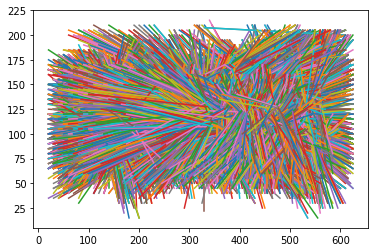

In [10]:
disp = 0

# read the file containing the frames where the mouse is walking, we're going to loop over these frames only.
filenames = open("../input/mouse-walking-data/mouse_walking.txt",'r').readlines()

# labels to indicies 
mapping = {'front right':0 ,'front left':1,'back right':2,'back left':3 , 'mouse':4}

# this file keep track of each image and the paw location used for fine-tunning yolo
ftext = open(save_path +"train.txt",'w')


# splitting filenames to be frames per video 
video_names = []
for f in filenames: 
    video_name_ = f.split('/')[-3]
    if video_name_ not in video_names:
        video_names.append(video_name_)
        
frames_per_video = {k : [] for k in video_names}
fs = []

for f in filenames: 
    video_name=  f.split('/')[-3]
    frames_per_video[video_name].append(f)

all_locations = []

for key in frames_per_video.keys(): 
    
    location_list = {} # keeping track of key locations per video

    filenames = frames_per_video[key]
    
    
    print(key)
    
    for filename in filenames:# looping over each frame
        
        fname = filename.split('/frames')
        frame_name = fname[-1]
        frame_name = frame_name.replace('/','')
        frame_name = frame_name.replace('.jpg\n','')
        filepath = '../input/mouse-on-treadmill-frames/frames/' + key + filename.split(key)[-1]
        filepath = filepath.replace('\n','')
        location_dictionary = {'mouse':0,'front right':0,'front left':0,'back left':0,'back right':0}
        locations = []
        try:
            frame = Image.open(filepath)

            arr = np.asarray(frame)
            arr_black1, rectangles,rectsB = mouse_mask(arr)
            xminM, yminM, xmaxM, ymaxM = detect_mouse_points(rectangles)

            mouse_location = (xminM, yminM, xmaxM, ymaxM , 'mouse') # mouse location - a big box surrounding the mouse body
            locations.append(mouse_location)


            if disp:
                ''' overlapping bounding boxes bounding box for the mouse'''
                figure, ax = plt.subplots(1,figsize=(20,20))
    #             rectMouse = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin, edgecolor='r', facecolor="none")
    #             ax.add_patch(rectMouse)

            # front paw
            arr_black,paw_rectangles,rectsA = front_paw_mask(arr,mouse_location)
            clusters = cluster_rectangles(paw_rectangles)
            
            if clusters:
                for paw_rectangle in clusters:
                    xmin, ymin, xmax, ymax = detect_mouse_points(paw_rectangle)
                    paw_location = (xmin, ymin, xmax, ymax , 'paw')
                    locations.append(paw_location)

            # back paw
            arr_black,paw_rectangles,rectsA = back_paw_mask(arr,mouse_location)
            clusters = cluster_rectangles(paw_rectangles)
            
            if clusters:
                for paw_rectangle in clusters:
                    xmin, ymin, xmax, ymax = detect_mouse_points(paw_rectangle)
                    paw_location = (xmin, ymin, xmax, ymax , 'paw')
                    locations.append(paw_location)


            loc_ = assign_location(locations)

            string_to_write = filepath

            for loc in loc_:

                xmin = loc[0]
                ymin = loc[1]
                xmax = loc[2]
                ymax = loc[3]
                paw_name = loc[4]

                center_loc, paw_loc = plot_line(mouse_location,loc)
                location_dictionary[paw_name] = paw_loc

                if paw_name != 'mouse': # don't add mouse, it overlaps with all paws
                    string_to_write += " " + str(xmin) + "," + str(ymin) + "," + str(xmax) + "," + str(ymax) + "," + str(mapping[paw_name])
                
                if disp:
                    '''
                    overlapping bounding boxes for the paws with labels
                    '''
                    rectPaw = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,label=loc[-1],edgecolor='g', facecolor="none")
                    ax.add_patch(rectPaw)
                    rx, ry = rectPaw.get_xy()
                    cx = rx + rectPaw.get_width()/2.0
                    cy = ry + rectPaw.get_height()/2.0
                    ax.annotate(rectPaw.get_label(), (cx, cy), color='black', fontsize=16, ha='center', va='center')

            if len(loc_)>1: # saving only those where at least one paws where detected 
                ftext.write(string_to_write + '\n')

            location_list[frame_name] = location_dictionary

            if disp:
                #main bounding box for mouse body
    #             for rect in rectsB:
    #                 ax.add_patch(rect)
    #             # main bounding boxes for mouse paws
    #             for rect in rectsA:
    #                 ax.add_patch(rect)
                ax.imshow(arr)
                plt.show()
                time.sleep(0.5)
                clear_output(wait=True)
        except: 
            print(filename)
            
    all_locations.append(location_list)
    pickle.dump(all_locations,open(save_path + "all_locations.pickle",'wb'))
    
ftext.close()